
=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== Dataset Description ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531  

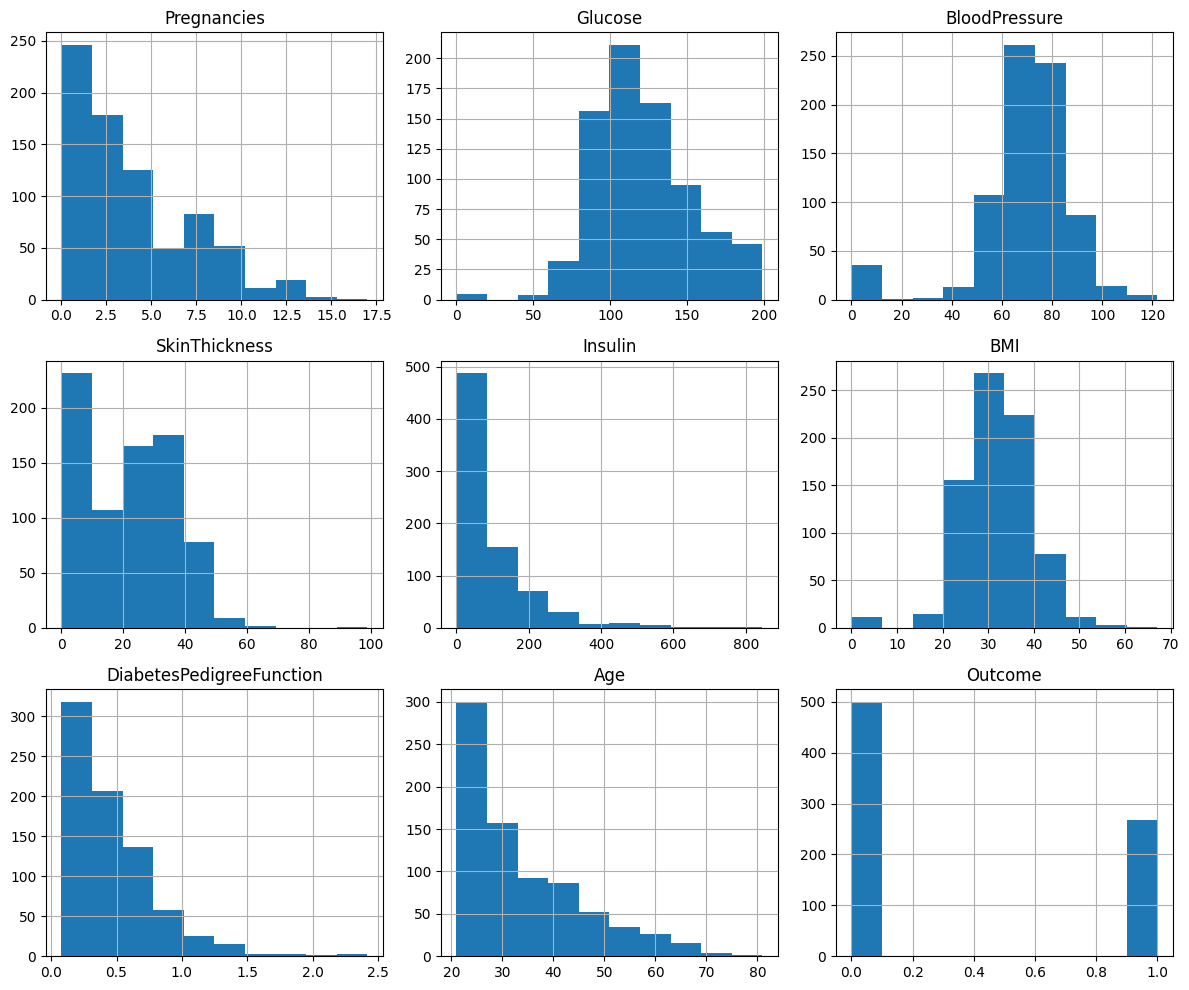


=== Class Distribution ===
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


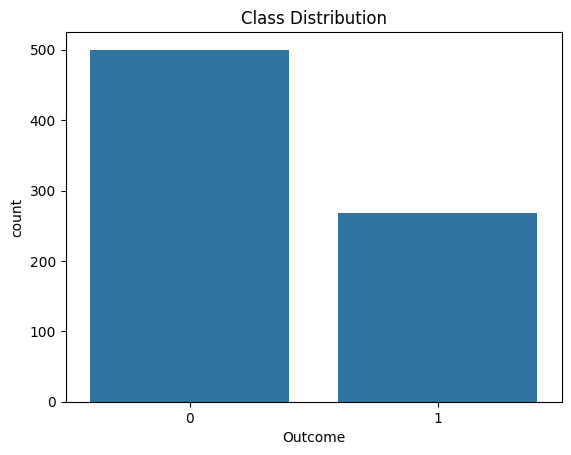


=== Class Distribution After SMOTE ===
Outcome
1    0.5
0    0.5
Name: proportion, dtype: float64

=== Cross-Validation ROC-AUC Scores: [0.86337778 0.85466667 0.86488889 0.90728889 0.88533333] ===
Mean CV ROC-AUC: 0.875

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       125
           1       0.80      0.85      0.82       125

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250


=== ROC-AUC Score ===
ROC-AUC: 0.902


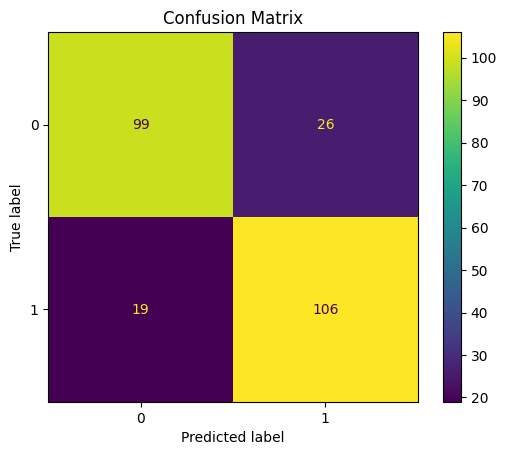

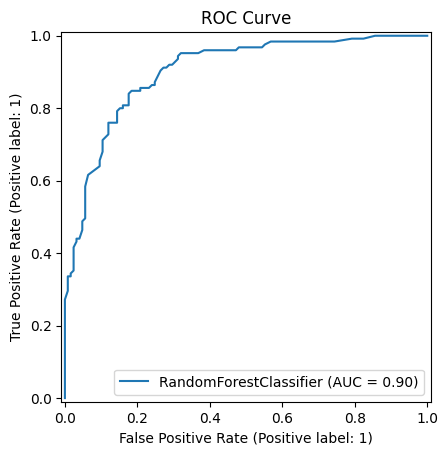

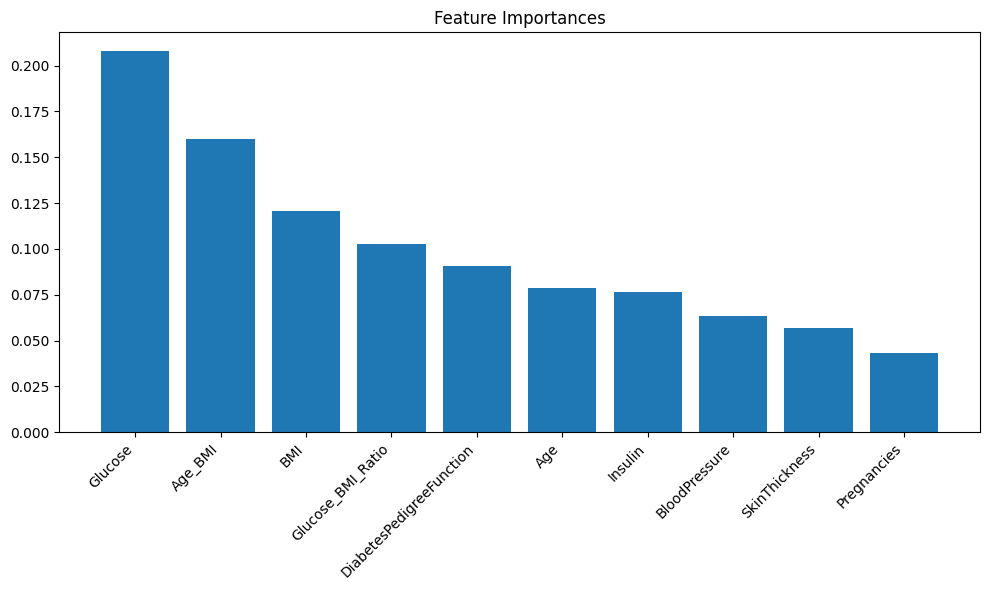


=== SHAP Analysis ===
Using new SHAP API
SHAP values shape: (750, 10, 2)


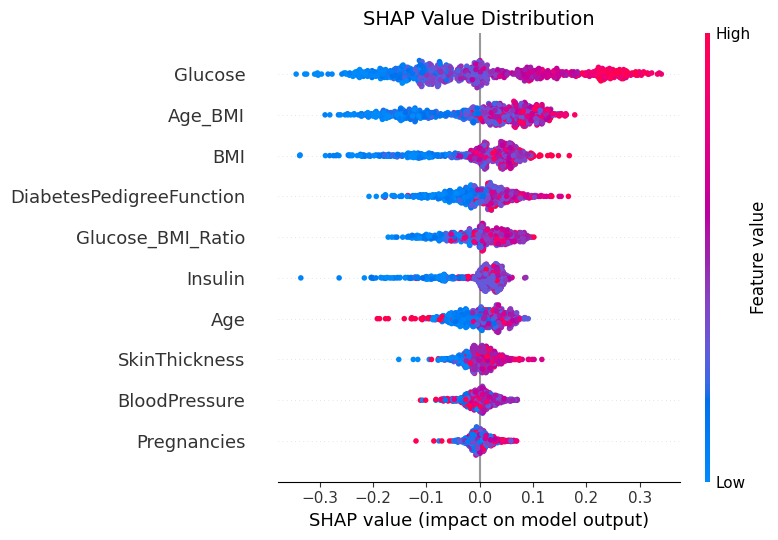

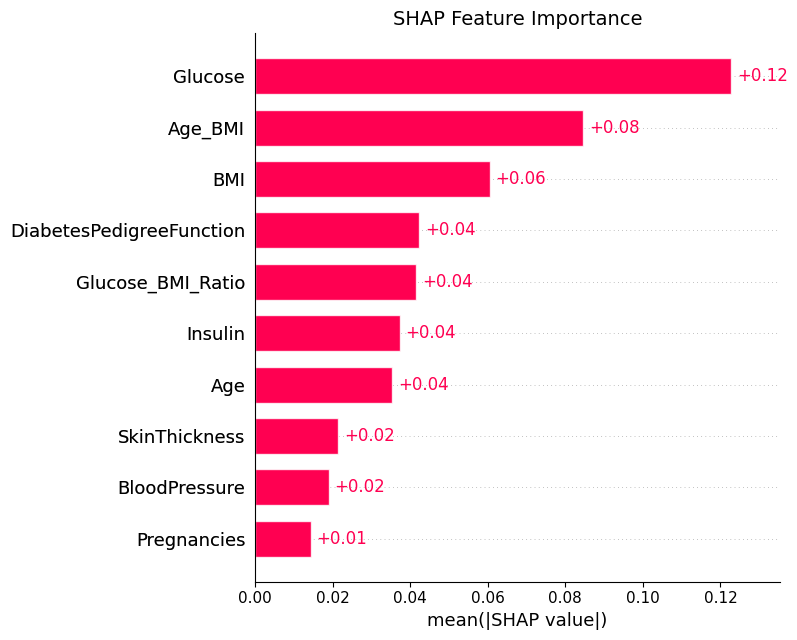

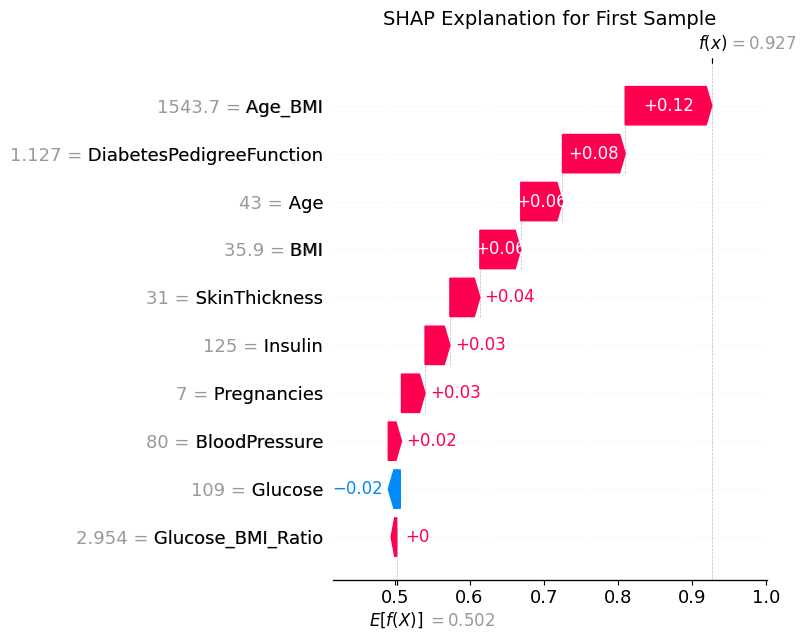

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load Dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
           'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Step 1.5: Exploratory Data Analysis (EDA)
print("\n=== Dataset Info ===")
print(data.info())
print("\n=== Dataset Description ===")
print(data.describe())

# Plot histograms for all features
data.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Check class balance
print("\n=== Class Distribution ===")
print(data['Outcome'].value_counts(normalize=True))
sns.countplot(x='Outcome', data=data)
plt.title('Class Distribution')
plt.show()

# Step 2: Handle zeros as NaN and fill
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[col] = data[col].replace(0, np.nan)
    data[col] = data[col].fillna(data[col].median())

# Step 3: Feature Engineering
data['Age_BMI'] = data['Age'] * data['BMI']
data['Glucose_BMI_Ratio'] = data['Glucose'] / (data['BMI'] + 1)

# Step 4: Split X and y
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Step 4.5: Handle Class Imbalance (optional)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("\n=== Class Distribution After SMOTE ===")
print(pd.Series(y_res).value_counts(normalize=True))

# Step 5: Train-Test Split (using resampled data)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.25, random_state=42, stratify=y_res
)

# Step 6: Normalize (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Step 7: Train RandomForest
model = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
model.fit(X_train_scaled_df, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled_df, y_train, cv=5, scoring='roc_auc')
print(f"\n=== Cross-Validation ROC-AUC Scores: {cv_scores} ===")
print(f"Mean CV ROC-AUC: {np.mean(cv_scores):.3f}")

# Step 8: Evaluate
y_pred = model.predict(X_test_scaled_df)
y_proba = model.predict_proba(X_test_scaled_df)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== ROC-AUC Score ===")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test_scaled_df, y_test)
plt.title('ROC Curve')
plt.show()

# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Train model on unscaled data for SHAP
model_unscaled = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
model_unscaled.fit(X_train, y_train)

# Step 9: SHAP Analysis - COMPLETE WORKING VERSION
print("\n=== SHAP Analysis ===")

# 1. Prepare the explainer
explainer = shap.TreeExplainer(model_unscaled)

# 2. Get SHAP values - handle both old and new SHAP versions
try:
    # New SHAP version (returns Explanation object)
    shap_values = explainer(X_train)
    print("Using new SHAP API")
    print(f"SHAP values shape: {shap_values.values.shape}")

    # For binary classification, we need to select one class
    if len(shap_values.values.shape) == 3 and shap_values.values.shape[2] == 2:
        shap_values_positive = shap_values[..., 1]  # Positive class
    else:
        shap_values_positive = shap_values

except:
    # Old SHAP version (returns list of arrays)
    shap_values = explainer.shap_values(X_train)
    print("Using old SHAP API")
    if isinstance(shap_values, list):
        print(f"SHAP values list length: {len(shap_values)}")
        shap_values_positive = shap_values[1]  # Positive class
    else:
        shap_values_positive = shap_values

# 3. Visualizations that work with both versions
plt.figure(figsize=(10, 6))

# A. Beeswarm plot (most reliable)
try:
    if 'Explanation' in str(type(shap_values)):
        shap.plots.beeswarm(shap_values_positive, show=False)
    else:
        shap.summary_plot(shap_values_positive, X_train, show=False)
    plt.title("SHAP Value Distribution", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create beeswarm plot: {e}")

# B. Bar plot (mean absolute SHAP)
try:
    if 'Explanation' in str(type(shap_values)):
        shap.plots.bar(shap_values_positive, show=False)
    else:
        shap.summary_plot(shap_values_positive, X_train, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create bar plot: {e}")

# C. Force plot for first observation
try:
    plt.figure()
    if 'Explanation' in str(type(shap_values)):
        shap.plots.waterfall(shap_values_positive[0], show=False)
    else:
        shap.initjs()
        shap.force_plot(explainer.expected_value[1],
                       shap_values_positive[0,:],
                       X_train.iloc[0,:],
                       matplotlib=True,
                       show=False)
    plt.title("SHAP Explanation for First Sample", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create force plot: {e}")

# D. Dependence plot for top feature
try:
    # Get top feature from SHAP values
    if 'Explanation' in str(type(shap_values_positive)):
        mean_abs_shap = np.abs(shap_values_positive.values).mean(0)
    else:
        mean_abs_shap = np.abs(shap_values_positive).mean(0)

    top_feature_idx = np.argmax(mean_abs_shap)
    top_feature = X_train.columns[top_feature_idx]

    plt.figure()
    if 'Explanation' in str(type(shap_values)):
        shap.plots.scatter(shap_values_positive[:, top_feature],
                         color=shap_values_positive,
                         show=False)
    else:
        shap.dependence_plot(top_feature_idx,
                           shap_values_positive,
                           X_train,
                           interaction_index=None,
                           show=False)
    plt.title(f"SHAP Dependence: {top_feature}", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create dependence plot: {e}")